# Maximum Entropy Inverse Reinforcement Learning

The code in this notebook is based on the Maximum Entropy Inverse Reinforcement Learning paper by Ziebart et al. (2008).

_Disclaimer:_
The code provided in this notebook is written for readability.
In some sections, this has a considerable impact on performance:
Many operations, especially the ones involving the transition probability $P(s_k \mid s_i, a_j)$, can be reformulated as a combination or series of matrix multiplications. For an implementation considering these optimizations have a look at the accompanying python files.

## Introduction

The goal of reinforcement learning (RL) is to find an optimal sequence of actions (i.e. a policy $a = \pi(s)$ describing the optimal action $a$ for each state $s$) for an autonomous agent given a reward signal.
The reward signal provides feedback to the agent, affirming its behavior on actions that help further the goal of the task at hand, and punishing it on actions that are counter-productive to this goal.

Inverse reinforcement learning (IRL), as the name states, does exactly the inverse.
Given demonstrations of an expert (agent), consisting of trajectories $\tau$ through the state-action space, IRL aims to recover the underlying reward function which explains the behavior of the expert.

TODO: MDPs, features, policies

### The Principle of Maximum Entropy

The general idea of Maximum Entropy Inverse Reinforcement Learning is based on feature-expectation matching [\[Abbel & Ng 2004\]](#References):
The expected visitation-frequency of features in the demonstrations provided by the expert should equal the exected visitation-frequency of features visited by the agent following the recovered reward function.
In other words: The features describing the states of our world should be, in expectance, visited equally often by the agent following our recovered reward function and by the expert demonstrating (nearly) optimal behavior.
In equations, we can express this as the expectation of features $\phi$ over trajectories $\tau$derived from the reward we want to recover, and 

\\[
    \mathbb{E}_{\pi^L}[\phi(\tau)] = \mathbb{E}_{\pi^E}[\phi(\tau)],
\\]

where the learner follows a policy $\pi^L$ directly implied by the reward we want to recover.
The expert follows an implicit policy $\pi^E$ that encodes its notion of reward and optimality.
Note that we can also express the expected feature visitation frequency as sum over trajectories

\\[
    \mathbb{E}_{\pi^L}[\phi(\tau)] = \sum_{\tau} p_{\pi^L}(\tau) \phi(\tau)
\\]

with the probability distribution $p_{\pi^L}(\tau)$ of trajectories of the learner. Finding such a match, however, is not a well-posed problem in accordance to the definition by Hadamard: There is not the single one, but many possible solutions.
Multiple reward functions can achieve the same expected feature-visitation frequency [\[Ng et al. 99; Abbel & Ng 2004; Ziebart 2010\]](#References).
To resolve this ambiguity, Ziebart et al. [\[Ziebart et al. 2008\]](#References). propose to choose the solution (i.e. the $p_{\pi^L}$) maximizing the entropy.

But why should we maximize the entropy?
To answer this, we have to understand what entropy represents.
First of all, the entropy $H(p)$ of some event probability distribution $p$ is defined as

\\[
    H(p)
    = -\sum_{x \in \mathcal{X}} p(x) \log_2 p(x)
    = \sum_{x \in \mathcal{X}} p(x) \cdot \log_2 \frac{1}{p(x)},
\\]

where $X$ is the set containing all events $x$ and $p(x)$ the probability of event $x$ occurring.
Let us now assume that we want to communicate the occurrence of all events $x$ with some other party in an efficient manner.
To do this, we want to minimize the expected message length, so messages that will be sent frequently should be short, and messages that will be sent almost never are allowed to be long.
Following this trail of thought leads to the term $h(x) = \log_2(1/p(x))$, which is the optimal number of bits that we should spend on the message representing event $x$.
With lower probability $p(x)$, the term $\log_2(1/p(x))$ increases.
In fact it increases logarithmically, as with more bits available, we can encode exponentially more events.
Using this observation for the entropy $H$ then yields nothing more than the entropy being the lower limit of the expected message length over all messages, i.e.:

\\[
    H(p)
    = \mathbb{E}_{p(x)}\left[h(x)\right].
\\]

Note that this is in fact the underlying principle of Huffman coding (which, due to this relation, is guaranteed to be optimal9.
As is done generally, we instead of the logarithm to base two use the normal logarithm.
Since $\log_2(x) = \log(x)/\log(2)$ holds, we are only dropping a constant factor of $\log(2)$ which does not impact extremas or our reasoning below, and simplifies further computations.

With that in mind, let us ask again:
Why should we maximize the entropy?
Now we can give a simple reasoning [\[Jaynes 1957\]](#References):
Let us assume that we have two distributions, $p_1$ and $p_2$, with entropies $H(p_1) > H(p_2)$.
From our previous observations, we know now that to encode messages from $p_1$ we, in expectancy, need more bits than to encode messages from $p_2$.
This is the key point, because this in turn also means that we have less information about $p_1$ than about $p_2$.
If we know more about a distribution, we need less bits to encode events from it.
If we know everything, we do not need to send/encode anything, and if we know nothing, we need to send everything.

But isn't it good if we know more? The less entropy the better, right? you may ask.
No.
Not for many optimization problems:
Consider a problem, like feature-expectation matching, which has many solutions fullfilling our constraints.
The only information which we give our solver for this problem is the feature-expectations we want to replicate.
All solutions provided by our solver contain this information.
Yet they most certainly have a different entropy values.
This must mean that (at least) some solutions have additional information that we did not provide, i.e. they have a bias.
By choosing the solution with maximum entropy, we choose the solution with minimal information.
Note that all solutions already satisfy our constraints, thus we actually choose the solution that fits our information with a minimal bias.

### Maximum Entropy Inverse Reinforcement Learning

Applying our findings from the previous section to feature-expectation matching directly results in a constrained optimization problem:

\\[\DeclareMathOperator{\argmax}{arg\,max}
\begin{alignat*}{2}
    \argmax_p\quad
        && H(p) \\
    \text{subject to}\quad
        && \mathbb{E}_{\pi^L}[\phi(\tau)] &= \mathbb{E}_{\pi^E}[\phi(\tau)],
            \tag{feature-expectation matching} \\
        && \sum_{\tau} p(\tau) = 1, &\quad \forall \tau : p(\tau) &> 0
            \tag{probability constraints}
\end{alignat*}
\\]

This problem expresses that we want to find a probability distribution $p(\tau)$ over trajectories $\tau$ with maximum entropy, under which the expected feature visitation frequencies of learner $\mathbb{E}_{\pi^L}[\phi(\tau)]$ and expert $\mathbb{E}_{\pi^E}[\phi(\tau)]$ match (that $\phi(\tau)$ represents the features visited by trajectory $\tau$).
Note that the policy $\pi^L$ of the learner depends on the probability distribution $p(\tau)$:
\\[
    \pi^L(a \mid s) \propto \sum_{\tau : (s, a) \in \tau} p(\tau),
\\]
i.e. the policy of the learner is proportional to the sum of the probabilities of all trajectories performing action $a$ in state $s$.

Now we have the probability distribution over trajectories, but how does this help us to recover the reward function $R: S \to \mathbb{R}$?
Following the school of basic reinforcement learning provides us with the answer: The reward dictates the policy, which in turn dictates the trajectory distribution $p(\tau)$.
A key assumption of Maximum Entropy IRL is that we know the behavior of our MDP, i.e. we have a perfect model representing the transition probabilities $p(s_{t+1} \mid s_t, a_t)$, so the only thing we actually need to learn is the reward.
Everything else either is derived from it or assumed known.
To be able to learn the reward, we need to parameterize it.
For this we assume linearity with regards to features, i.e.

\\[
    R(\tau) = \omega^\top \phi(\tau)
\\]

with $\omega \in \mathbb{R}^d$ being the reward parameter vector.
To make this dependency on the reward parameters explicit, we write $p(\tau \mid \omega)$ (and $\pi(a \mid s, \omega)$).

Solving the above mathematical program for MDPs with deterministic transition dynamics (i.e. MDPs where all actions have predetermined deterministic outcomes) leads to the observation that

\\[
    p_d(\tau \mid \omega) = \frac{1}{Z(\omega)} \exp \left( \omega^\top \phi(\tau) \right),
    \qquad
    Z(\omega) = \sum_{\tau} \exp \left( \omega^\top \phi(\tau) \right)
\\]

with the so-called partition function $Z(\omega)$ simply normalizing the values to fullfill the probability distribution constraint [\[Ziebart et al. 2008; Osa et al. 2018\]](#References).
By choosing the reward to linearly depend on the features, we have also ensured that the Lagrangian multipliers are exactly the reward parameters $\omega$ [\[Osa et al. 2018\]](#References).
For MDPs with stochastic transitions, Ziebart et al. [\[Ziebart et al. 2008\]](#References) propose to modify the deterministic solution yielding the approximation

\\[
    p_s(\tau \mid \omega)
    \approx
        \frac{1}{Z(\omega)} \exp\left( \omega^\top \phi(\tau) \right)
        \prod_{x_{t+1}, a_t, x_t \in \tau} p(x_{t+1} \mid x_t, a_t).
\\]

Note that we're simply multiplying the deterministic solution with combined transition probability of the trajectory.
As a result of said modification, however, we introduce a bias to the reward function [\[Osa et al. 2018\]](#References).
To avoid this, Ziebart [\[Ziebart 2010\]](#References) proposes the Maximum Causal Entropy IRL method in his thesis.
In the scope of this notebook, we'll stick to the normal (non-causal) entropy.

We now know the parameterized form of the distribution, so how can we optimize the parameters?
The answer is fairly straightforward: We maximize the log-likelihood over all demonstrated trajectories $D$, i.e.

\\[\DeclareMathOperator*{\argmax}{arg\,max}
    \omega^* = \argmax_{\omega} \sum_{\tau \in D} \log p(\tau \mid \omega),
\\]

using gradient ascent.


TODO: gradient, outlook for stuff below (expected state-visitation frequency computation etc.)

## Preparation

TODO

In [1]:
# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../src')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [3]:
import gridworld as W    # basic grid-world MDPs
import trajectory as T   # trajectory generation
import optimizer as O    # stochastic gradient descent optimizer
import solver as S       # MDP solver (value-iteration)
import plot as P         # helper-functions for plotting

In [4]:
%matplotlib notebook
style = {
    'border': {'color': 'red', 'linewidth': 0.5},
}

In [5]:
def setup_mdp():
    # create our world
    world = W.IcyGridWorld(size=5, p_slip=0.2)

    # set up the reward function
    reward = np.zeros(world.n_states)
    reward[-1] = 1.0
    reward[8] = 0.65

    # set up terminal states
    terminal = [24]

    return world, reward, terminal

# set-up the GridWorld Markov Decision Process
world, reward, terminal = setup_mdp()

In [6]:
def generate_expert_trajectories(world, reward, terminal):
    n_trajectories = 200         # the number of "expert" trajectories
    discount = 0.9               # discount for constructing an "expert" policy
    weighting = lambda x: x**50  # down-weight less optimal actions
    start = [0]                  # starting states for the expert

    # compute the value-function
    value = S.value_iteration(world.p_transition, reward, discount)
    
    # create our stochastic policy using the value function
    policy = S.stochastic_policy_from_value(world, value, w=weighting)
    
    # a function that executes our stochastic policy by choosing actions according to it
    policy_exec = T.stochastic_policy_adapter(policy)
    
    # generate trajectories
    tjs = list(T.generate_trajectories(n_trajectories, world, policy_exec, start, terminal))
    
    return tjs, policy

# generate some "expert" trajectories (and its policy for visualization)
trajectories, expert_policy = generate_expert_trajectories(world, reward, terminal)

<IPython.core.display.Javascript object>


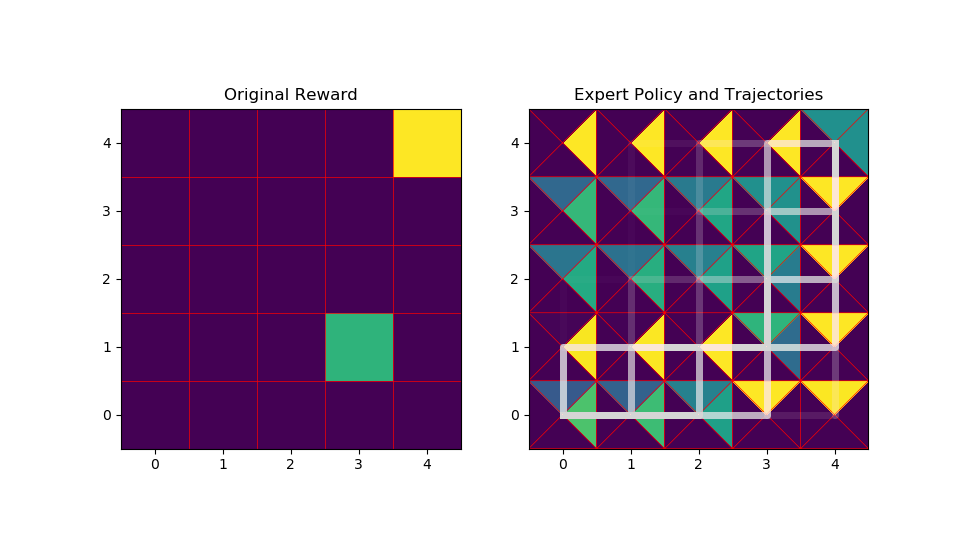

In [7]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
P.plot_state_values(ax, world, reward, **style)

ax = fig.add_subplot(122)
ax.title.set_text('Expert Policy and Trajectories')
P.plot_stochastic_policy(ax, world, expert_policy, **style)

for t in trajectories:
    P.plot_trajectory(ax, world, t, lw=5, color='white', alpha=0.025)

plt.show()

In [8]:
def feature_expectation_from_trajectories(features, trajectories):
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:
        for s in t.states():
            fe += features[s, :]

    return fe / len(trajectories)

In [9]:
def initial_probabilities_from_trajectories(n_states, trajectories):
    p = np.zeros(n_states)

    for t in trajectories:
        p[t.transitions()[0][0]] += 1.0

    return p / len(trajectories)

In [10]:
def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    n_states, _, n_actions = p_transition.shape
    nonterminal = set(range(n_states)) - set(terminal)  # nonterminal states
    
    # Backward Pass
    # 1. initialize at terminal states
    zs = np.zeros(n_states)                             # zs: state partition function
    zs[terminal] = 1.0

    # 2. perform backward pass
    for _ in range(2 * n_states):                       # longest trajectory: n_states
        # reset action values to zero
        za = np.zeros((n_states, n_actions))            # za: action partition function

        # for each state-action pair
        for s_from, a in product(range(n_states), range(n_actions)):

            # sum over s_to
            for s_to in range(n_states):
                za[s_from, a] += p_transition[s_from, s_to, a] * np.exp(reward[s_from]) * zs[s_to]
        
        # sum over all actions
        zs = za.sum(axis=1)

    # 3. compute local action probabilities
    p_action = za / zs[:, None]

    # Forward Pass
    # 4. initialize with starting probability
    d = np.zeros((n_states, 2 * n_states))              # d: state-visitation frequencies
    d[:, 0] = p_initial

    # 5. iterate for N steps
    for t in range(1, 2 * n_states):                    # longest trajectory: n_states
        
        # for all states
        for s_to in range(n_states):
            
            # sum over nonterminal state-action pairs
            for s_from, a in product(nonterminal, range(n_actions)):
                d[s_to, t] += d[s_from, t-1] * p_action[s_from, a] * p_transition[s_from, s_to, a]

    # 6. sum-up frequencies
    return d.sum(axis=1)

In [11]:
def maxent_irl(p_transition, features, terminal, trajectories, optim, init, eps=1e-4):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute feature expectation from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)
    
    # compute starting-state probabilities from trajectories
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    # gradient descent optimization
    omega = init(n_features)        # initialize our parameters
    delta = np.inf                  # initialize delta for convergence check

    optim.reset(omega)              # re-start optimizer
    while delta > eps:              # iterate until convergence
        omega_old = omega.copy()

        # compute per-state reward from features
        reward = features.dot(omega)

        # compute gradient of the log-likelihood
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward)
        grad = e_features - features.T.dot(e_svf)

        # perform optimization step and compute delta for convergence
        optim.step(grad)
        
        # re-compute detla for convergence check
        delta = np.max(np.abs(omega_old - omega))

    # re-compute per-state reward and return
    return features.dot(omega)

In [12]:
# set up features: we use one feature vector per state
features = W.state_features(world)

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.2))

# actually do some inverse reinforcement learning
reward_maxent = maxent_irl(world.p_transition, features, terminal, trajectories, optim, init)

<IPython.core.display.Javascript object>


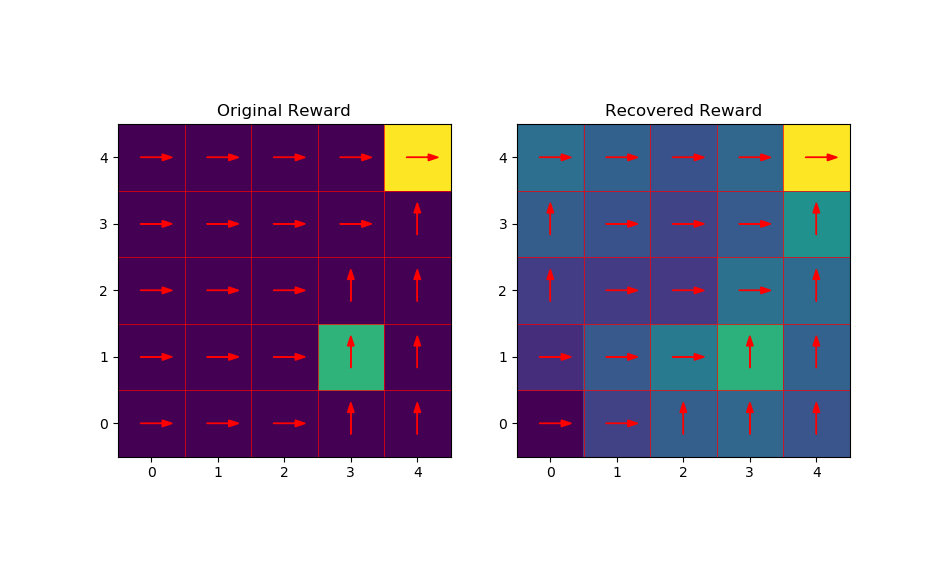

In [13]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
P.plot_state_values(ax, world, reward, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward, 0.8), color='red')

ax = fig.add_subplot(122)
ax.title.set_text('Recovered Reward')
P.plot_state_values(ax, world, reward_maxent, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward_maxent, 0.8), color='red')

plt.show()

<IPython.core.display.Javascript object>


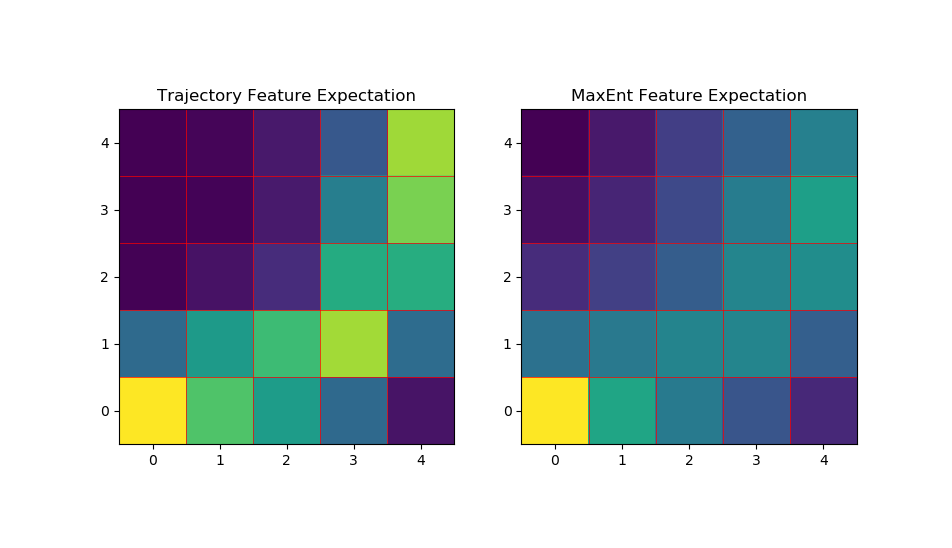

In [14]:
p_initial = initial_probabilities_from_trajectories(world.n_states, trajectories)
e_svf = compute_expected_svf(world.p_transition, p_initial, terminal, reward_maxent)
e_features = feature_expectation_from_trajectories(features, trajectories)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Trajectory Feature Expectation')
P.plot_state_values(ax, world, e_features, **style)

ax = fig.add_subplot(122)
ax.title.set_text('MaxEnt Feature Expectation')
P.plot_state_values(ax, world, features.T.dot(e_svf), **style)

plt.show()

## References

- \[Abbel & Ng 2004\]: https://ai.stanford.edu/~ang/papers/icml04-apprentice.pdf
- \[Jaynes 1957\]: https://bayes.wustl.edu/etj/articles/theory.1.pdf
- \[Ng et al. 99\]: https://people.eecs.berkeley.edu/~pabbeel/cs287-fa09/readings/NgHaradaRussell-shaping-ICML1999.pdf
- \[Osa et al. 2018\]: https://arxiv.org/abs/1811.06711
- \[Ziebart et al. 2008\]: https://www.aaai.org/Papers/AAAI/2008/AAAI08-227.pdf
- \[Ziebart 2010\]: https://www.cs.cmu.edu/~bziebart/publications/thesis-bziebart.pdf